## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
import cv2 
import os 
from tqdm import tqdm
import pickle
from keras.models import Sequential
from tqdm import tqdm
import urllib.request
import requests
from PIL import ImageFile

2023-01-29 10:55:46.490092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 10:55:46.780710: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-29 10:55:46.806857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-29 10:55:46.806880: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Importando Base de Dados

In [4]:
feData = pd.read_csv('data/ifood-restaurants-february-2021.csv')
noData = pd.read_csv('data/ifood-restaurants-november-2020.csv')

Visualizaçao parcial dos dados 

In [5]:
feData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406399 entries, 0 to 406398
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   availableForScheduling  406399 non-null  bool   
 1   avatar                  406122 non-null  object 
 2   category                406399 non-null  object 
 3   delivery_fee            406399 non-null  float64
 4   delivery_time           406399 non-null  int64  
 5   distance                406399 non-null  float64
 6   ibge                    406399 non-null  int64  
 7   minimumOrderValue       406399 non-null  float64
 8   name                    406399 non-null  object 
 9   paymentCodes            406397 non-null  object 
 10  price_range             406399 non-null  object 
 11  rating                  406399 non-null  float64
 12  tags                    406399 non-null  object 
 13  url                     406399 non-null  object 
dtypes: bool(1), float64(

## Limpando Dados

Iremos selecionar apenas os restaurantes que sobreviveram de novembro de 2020 até feveiro de 2021 (não incluiu restaurantes que fecharam antes de novembro de 2020)

In [6]:
data = feData[feData['url'].isin(noData['url'])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317191 entries, 0 to 406398
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   availableForScheduling  317191 non-null  bool   
 1   avatar                  316929 non-null  object 
 2   category                317191 non-null  object 
 3   delivery_fee            317191 non-null  float64
 4   delivery_time           317191 non-null  int64  
 5   distance                317191 non-null  float64
 6   ibge                    317191 non-null  int64  
 7   minimumOrderValue       317191 non-null  float64
 8   name                    317191 non-null  object 
 9   paymentCodes            317191 non-null  object 
 10  price_range             317191 non-null  object 
 11  rating                  317191 non-null  float64
 12  tags                    317191 non-null  object 
 13  url                     317191 non-null  object 
dtypes: bool(1), float64(

<AxesSubplot: ylabel='Frequency'>

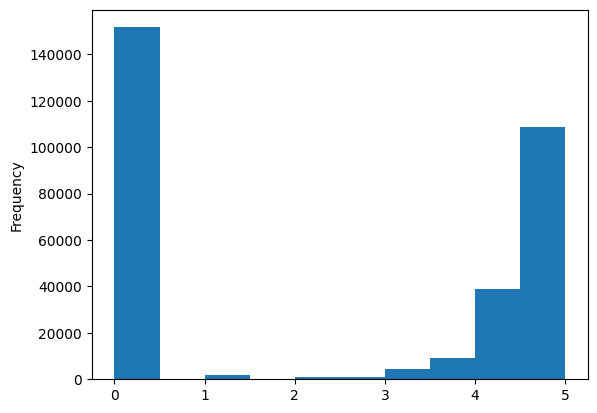

In [7]:
#plot 'rating' distribuition 
data['rating'].plot.hist(bins=10)

Visualizando as notas dos restaurantes selecionados

Iremos remover os restaurantes com avaliações iguais a **0** ou **5** para limpar os dados. Tais casos enquadram-se em restaurantes com nenhuma avaliação(nota 0), ou restaurantes com pouquissímas avaliações(nota 5) 

In [8]:
#removendo restaurantes com rating == 0 
data = data[(data['rating'] != 0)&(data['rating'] != 5)]
data = data.reset_index(drop=True)

<AxesSubplot: ylabel='Frequency'>

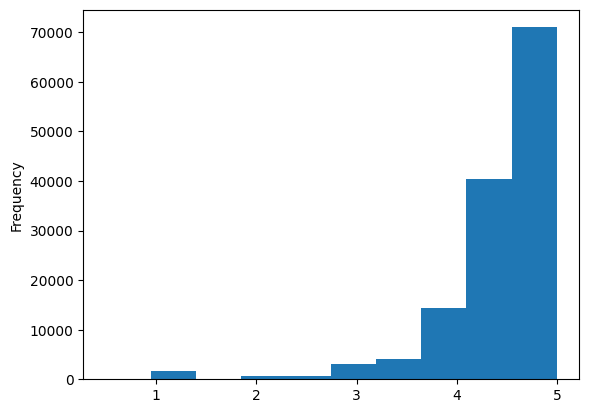

In [9]:
data['rating'].plot.hist(bins=10)

Nova distribuição de Notas após a redução

<AxesSubplot: >

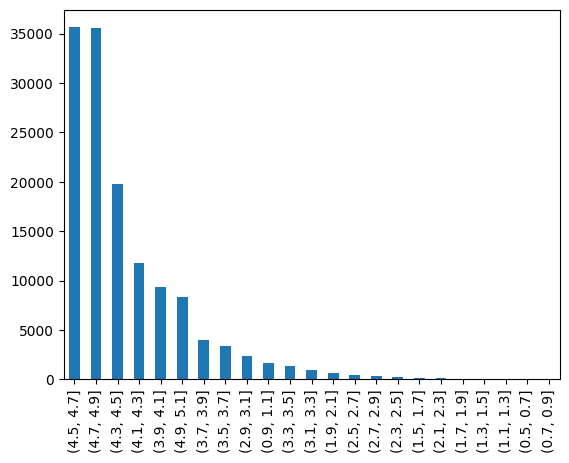

In [10]:
data['rating_bin'] = pd.cut(data['rating'], np.arange(0.5, 5.2, 0.2))
data['rating_bin'].value_counts().plot.bar()

Analisando o gráfico, podemos ver que as notas se aproximam, no geral, bastante de 5, por isso, para que possamos analisar as características dos restaurantes mais bem avaliados, podemos divdir o dataset em dois grupos. O grupo elite, com as maiores notas, deve conter os restaurantes com nota maior que 4,5. O grupo não-elite, com as menores notas, deve conter os restaurantes com nota menor que 4,5.

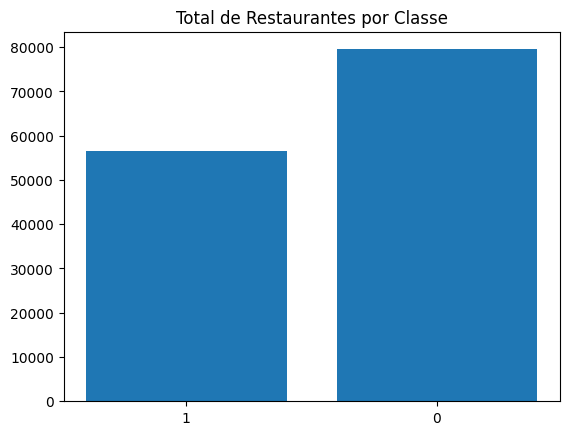

In [11]:
# at rating bin, if rating >= 4.5, rating_max = 1, else rating_max = 0
data['rating_max'] = data['rating'].apply(lambda x: 1 if x >= 4.5 else 0)


# Count the occurrences of each class
class_counts = data['rating_max'].value_counts()

# Create the bar plot
plt.bar(class_counts.index, class_counts.values)

plt.xticks(class_counts.index, ['0', '1'])
plt.title('Total de Restaurantes por Classe')
plt.show()

In [12]:
elite = data[data['rating_max'] == 1]
not_elite = data[data['rating_max'] == 0]

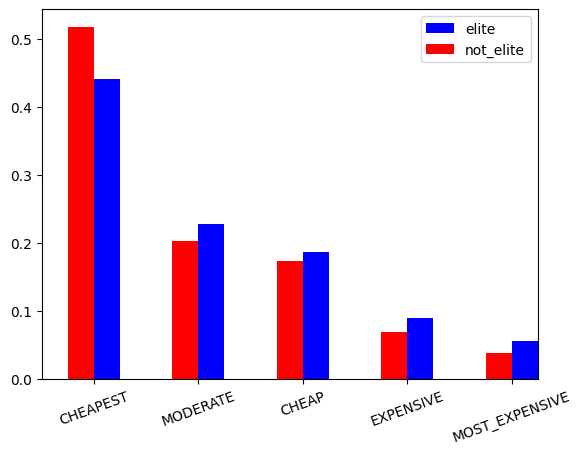

In [13]:
fig, ax = plt.subplots()
(elite['price_range'].value_counts()/elite['price_range'].count()).plot.bar(ax=ax, color='blue', position=0, width=0.25, label='elite')
(not_elite['price_range'].value_counts()/not_elite['price_range'].count()).plot.bar(ax=ax, color='red', position=1, width=0.25, label='not_elite')
plt.xticks(rotation=20)
plt.legend()
plt.show()

Visualização da presença de restaurantes da elite e da não elite nas diferentes modalidades de custo

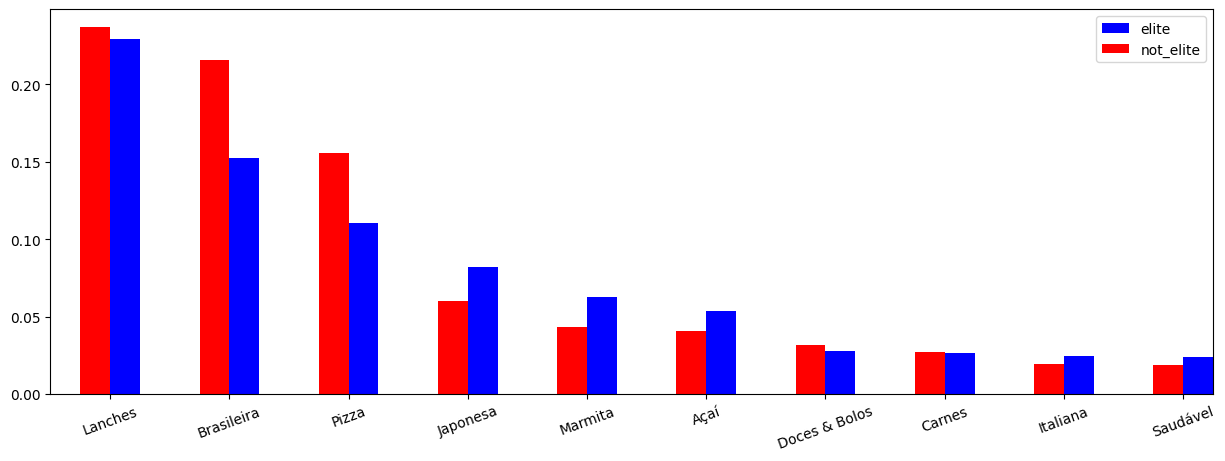

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
(elite['category'].value_counts()[elite['category'].value_counts() > 1000]/elite['category'].count()).plot.bar(ax=ax, color='blue', position=0, width=0.25, label='elite')
(not_elite['category'].value_counts()[not_elite['category'].value_counts() > 1000]/not_elite['category'].count()).plot.bar(ax=ax, color='red', position=1, width=0.25, label='not_elite')
plt.xticks(rotation=20)

plt.legend()
plt.show()

Visualização da presença de restaurantes da elite e da não elite nas diferentes modalidades de categoria

In [15]:
print('Tabelando valores médios para as modalidades Elite e Não_Elite:')
print('Tempo de entrega:')
print("Elite - {0:.3f}".format(elite['delivery_time'].mean()))
print("Não Elite - {0:.3f}\n".format(not_elite['delivery_time'].mean()))
print('Taxa de entrega:')
print("Elite - {0:.3f}".format(elite['delivery_fee'].mean()))
print("Não Elite - {0:.3f}\n".format(not_elite['delivery_fee'].mean()))
print('Consumassão mínima:')
print("Elite - {0:.3f}".format(elite['minimumOrderValue'].mean()))
print("Não Elite - {0:.3f}\n".format(not_elite['minimumOrderValue'].mean()))

Tabelando valores médios para as modalidades Elite e Não_Elite:
Tempo de entrega:
Elite - 44.049
Não Elite - 48.441

Taxa de entrega:
Elite - 7.044
Não Elite - 6.463

Consumassão mínima:
Elite - 15.734
Não Elite - 17.434



Com essa análise vemos que existe uma diferença, mesmo que pouca, entre os restaurantes da elite e do não elite. Com base nela, iremos tentar construir um modelo para classificação dos restaurantes.

## Aplicando Rede Neural

### Reconstruindo DataFrame para Aplica-lo na Rede

A princípio, precisamos reconstruir o DataFrame para valores que irão ser aceitos pela função de construção da rede.

*Falar sobre o processo de transformar string em ints e expamsão das colunas*

In [34]:
data_ml = pd.get_dummies(data, columns=['category','price_range'], prefix = ['category','price_range'])
data_ml['availableForScheduling'] = data['availableForScheduling'].apply(lambda x: 0 if x == 'False' else 1)
data_ml['isElite'] = data['rating'].apply(lambda x: 1 if x >= 4.5 else 0)
avatares = data_ml['avatar']
data_ml = data_ml.drop(['distance','ibge','name','paymentCodes','tags','url','rating','rating_max','rating_bin','avatar'], axis=1)

scaler = StandardScaler()
data_ml[['delivery_time','delivery_fee','minimumOrderValue']] = scaler.fit_transform(data_ml[['delivery_time','delivery_fee','minimumOrderValue']])

In [35]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136148 entries, 0 to 136147
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   availableForScheduling      136148 non-null  int64  
 1   delivery_fee                136148 non-null  float64
 2   delivery_time               136148 non-null  float64
 3   minimumOrderValue           136148 non-null  float64
 4   category_Africana           136148 non-null  uint8  
 5   category_Alemã              136148 non-null  uint8  
 6   category_Argentina          136148 non-null  uint8  
 7   category_Asiática           136148 non-null  uint8  
 8   category_Açaí               136148 non-null  uint8  
 9   category_Baiana             136148 non-null  uint8  
 10  category_Bebidas            136148 non-null  uint8  
 11  category_Brasileira         136148 non-null  uint8  
 12  category_Cafeteria          136148 non-null  uint8  
 13  category_Carne

In [36]:
#seleciona somente os restaurantes que tem uma imagem correspondente na pasta de imagens 
files = os.listdir('data/images')
files = [int(file.replace('.jpg','')) for file in files]


data_ml = data_ml.loc[files]

### Construindo Classificador para o DataFrame

Dividindo data_ml para treino e teste

In [24]:
#train test split
X = data_ml.drop(['isElite'], axis=1)
y = data_ml['isElite']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
#male a tensorflow MLP model to predict if a restaurant is elite or not

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)

2023-01-28 23:33:26.567890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/inpeace/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-28 23:33:26.568193: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-28 23:33:26.568227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Inpeaceapp
2023-01-28 23:33:26.568233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Inpeaceapp
2023-01-28 23:33:26.568343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-01-28 23:33:26.568378: I tensorflow/compiler/xla/stream_exec

Epoch 1/10
1668/1668 [==============================] - 2s 749us/step - loss: 0.6515 - accuracy: 0.6084
Epoch 2/10
1668/1668 [==============================] - 1s 671us/step - loss: 0.6463 - accuracy: 0.6138
Epoch 3/10
1668/1668 [==============================] - 1s 708us/step - loss: 0.6444 - accuracy: 0.6148
Epoch 4/10
1668/1668 [==============================] - 1s 702us/step - loss: 0.6432 - accuracy: 0.6163
Epoch 5/10
1668/1668 [==============================] - 1s 721us/step - loss: 0.6426 - accuracy: 0.6187
Epoch 6/10
1668/1668 [==============================] - 1s 717us/step - loss: 0.6414 - accuracy: 0.6194
Epoch 7/10
1668/1668 [==============================] - 1s 734us/step - loss: 0.6400 - accuracy: 0.6195
Epoch 8/10
1668/1668 [==============================] - 1s 699us/step - loss: 0.6394 - accuracy: 0.6213
Epoch 9/10
1668/1668 [==============================] - 1s 686us/step - loss: 0.6383 - accuracy: 0.6229
Epoch 10/10
1668/1668 [==============================] - 1s 700u

In [26]:
#validate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

417/417 - 0s - loss: 0.6489 - accuracy: 0.6141 - 250ms/epoch - 599us/step

Test accuracy: 0.6141100525856018


In [43]:
model.save('saved_models/model_tabular.h5')

### Baixando Logos

In [ ]:
# if not os.path.exists('data/images'):
#     os.makedirs('data/images')

# for i in tqdm(range(0, len(avatares))):
#     url = avatares.values[i]
#     try: 
#         response = requests.get(url)
#     except:
#         continue

#     if response.status_code:
#         try:
#             fp = open(f'data/images/{str(i)}.jpg', 'wb')
#             fp.write(response.content)
#             fp.close()

#             image = Image.open(f'data/images/{str(i)}.jpg')
#             image.thumbnail((64,64))
#             image.save(f'data/images/{str(i)}.jpg')
#         except:
#             continue
#     else:
#         continue

### Organizando Imagens em diretórios de treino e test, elite e não elite

In [ ]:
# X_tabular_train = []

# X_tabular_test = []
# y_tabular_train = []
# y_tabular_test = []

# ImageFile.LOAD_TRUNCATED_IMAGES = True

# def imagetensor(imagedir, X_tabular,y_tabular):
#   images = []
#   for i, im in tqdm(enumerate(os.listdir(imagedir))):
#     try:
#         print()
#         image= Image.open(imagedir + '/' + im)
#         image= image.convert('HSV')
#         X_tabular.append(data_ml.loc[int(j.split('.')[0])].drop(['isElite']))
#     except:
#         continue
#     if i == 0:
#       images= np.expand_dims(np.array(image, dtype= float)/255, axis= 0)
#     else:
#       image= np.expand_dims(np.array(image, dtype= float)/255, axis= 0)
#       try:
#         images= np.append(images, image, axis= 0)
#       except:
#         continue
#   return images, X_tabular, y_tabular

# X_train_0,X_tabular_train,y_tabular_train = imagetensor('data/train/0/',X_tabular_train, y_tabular_train)
# X_train_1,X_tabular_train,y_tabular_train = imagetensor('data/train/1/',X_tabular_train,y_tabular_train)
# X_test_0,X_tabular_test,y_tabular_test = imagetensor('data/test/0/',X_tabular_test,y_tabular_test)
# X_test_1,X_tabular_test,y_tabular_test = imagetensor('data/test/1/',X_tabular_test,y_tabular_test)

# X_train = np.concatenate((X_train_0, X_train_1), axis=0)
# X_test = np.concatenate((X_test_0, X_test_1), axis=0)


# pickle.dump(X_train, open('saved_models/X_train_g.pkl','wb'))
# pickle.dump(X_test, open('saved_models/X_test_g.pkl','wb'))

# pickle.dump(X_tabular_train, open('saved_models/X_tabular_train_g.pkl','wb'))
# pickle.dump(y_tabular_train, open('saved_models/y_tabular_train_g.pkl','wb'))
# pickle.dump(X_tabular_test, open('saved_models/X_tabular_test_g.pkl','wb'))
# pickle.dump(y_tabular_test, open('saved_models/y_tabular_test_g.pkl','wb'))

### Importando Imagens para treino e test

Testando o generator

In [28]:
# !pip install keras
# !pip install tensorflow

# Define the model
model_logo = Sequential()

# Add the convolutional layers
model_logo.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model_logo.add(MaxPooling2D(pool_size=(2, 2)))
model_logo.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_logo.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps and add the fully connected layers
model_logo.add(Flatten())
model_logo.add(Dense(128, activation='relu'))
model_logo.add(Dense(2, activation='softmax'))

# Compile the model
model_logo.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
X_train_tabular = []
X_test_tabular = []
y_train_tabular = []
y_test_tabular = []


#Xtrain is the data inside train_reduced folder, ytrain is the labels that are the names of the folders the data is in
#Xtest is the data inside test_reduced folder, ytest is the labels that are the names of the folders the data is in

X_train_logo = []
y_train_logo = []
#for each image in train_reduced folder, get the label and append it to ytrain
for i in os.listdir('data/train'):
    for j in tqdm(os.listdir('data/train/'+i)):
      
        #open the image and append it to Xtrain
        img = cv2.imread('data/train/'+i+'/'+j)
        if img is not None:
            y_train_logo.append(i)
            img = cv2.resize(img, (64,64))
            X_train_logo.append(img)
            X_train_tabular.append(data_ml.loc[int(j.split('.')[0])].drop(['isElite']))
            y_train_tabular.append(data_ml.loc[int(j.split('.')[0])]['isElite'])
    

X_test_logo = []
y_test_logo = []


#for each image in test_reduced folder, get the label and append it to ytest
for i in os.listdir('data/test'):
    for j in tqdm(os.listdir('data/test/'+i)):
        #open the image and append it to Xtest
        img = cv2.imread('data/test/'+i+'/'+j)
        if img is not None:
            img = cv2.resize(img, (64,64))
            y_test_logo.append(i)
            X_test_logo.append(img)
            X_test_tabular.append(data_ml.loc[int(j.split('.')[0])].drop(['isElite']))
            y_test_tabular.append(data_ml.loc[int(j.split('.')[0])]['isElite'])

100%|██████████| 7030/7030 [00:03<00:00, 2089.41it/s]


In [44]:
#save the data 
pickle.dump(X_train_logo, open('pkl_files//X_train_logo.pkl','wb'))
pickle.dump(y_train_logo, open('pkl_files//y_train_logo.pkl','wb'))
pickle.dump(X_test_logo, open('pkl_files//X_test_logo.pkl','wb'))
pickle.dump(y_test_logo, open('pkl_files//y_test_logo.pkl','wb'))

pickle.dump(X_train_tabular, open('pkl_files//X_train_tabular.pkl','wb'))
pickle.dump(y_train_tabular, open('pkl_files//y_train_tabular.pkl','wb'))
pickle.dump(X_test_tabular, open('pkl_files//X_test_tabular.pkl','wb'))
pickle.dump(y_test_tabular, open('pkl_files//y_test_tabular.pkl','wb'))

In [45]:
#laod data 
X_train_logo = pickle.load(open('pkl_files//X_train_logo.pkl','rb'))
y_train_logo = pickle.load(open('pkl_files//y_train_logo.pkl','rb'))
X_test_logo = pickle.load(open('pkl_files//X_test_logo.pkl','rb'))
y_test_logo = pickle.load(open('pkl_files//y_test_logo.pkl','rb'))

X_train_tabular = pickle.load(open('pkl_files//X_train_tabular.pkl','rb'))
y_train_tabular = pickle.load(open('pkl_files//y_train_tabular.pkl','rb'))
X_test_tabular = pickle.load(open('pkl_files//X_test_tabular.pkl','rb'))
y_test_tabular = pickle.load(open('pkl_files//y_test_tabular.pkl','rb'))

### Construindo Classificador para as Logos

In [38]:
#convert y_train_logo to float32
y_train_logo = np.array(y_train_logo).astype('float32')
y_test_logo = np.array(y_test_logo).astype('float32')

In [39]:
#import sequential
# Training the model
model_logo.fit(np.array(X_train_logo),y_train_logo,epochs=5)

Epoch 1/5
1549/1549 [==============================] - 45s 29ms/step - loss: 0.6510 - accuracy: 0.6100
Epoch 2/5
1549/1549 [==============================] - 45s 29ms/step - loss: 0.6352 - accuracy: 0.6211
Epoch 3/5
1549/1549 [==============================] - 45s 29ms/step - loss: 0.6197 - accuracy: 0.6330
Epoch 4/5
1549/1549 [==============================] - 45s 29ms/step - loss: 0.6065 - accuracy: 0.6418
Epoch 5/5
1549/1549 [==============================] - 46s 29ms/step - loss: 0.5940 - accuracy: 0.6486


In [40]:
#validate the model
model_logo.evaluate(np.array(X_test_logo),y_test_logo)

521/521 [==============================] - 5s 9ms/step - loss: 0.8527 - accuracy: 0.5666


[0.8526797294616699, 0.5665586590766907]

In [41]:
#save model 
model_logo.save('saved_models/model_logo.h5') 

### Classificador Global

In [42]:
# Assume the two pre-trained models are named "model_1" and "model_2"
# and their input and output tensors are named "input_1" and "output_1" for model_1,
# and "input_2" and "output_2" for model_2

# Create the input tensors for the two models
input_1 = tf.keras.layers.Input(shape=(69,))
input_2 = tf.keras.layers.Input(shape=(64, 64, 3))

# Connect the input tensors to the pre-trained models
output_1 = model(input_1)
output_2 = model_logo(input_2)

# Concatenate the output tensors from the two models
concatenated = tf.keras.layers.concatenate([output_1, output_2])

#another layer 
concatenated = tf.keras.layers.Dense(units=32, activation='relu')(concatenated)

# Add a fully connected layer to the concatenated output
output = tf.keras.layers.Dense(units=2, activation='softmax')(concatenated)

# Create a new model with the input and output tensors
final_model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=[output])

# Compile the final model
final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
final_model.fit([np.array(X_train_tabular), np.array(X_train_logo)], y_train_logo, epochs=5, batch_size=32)

Epoch 1/5
1549/1549 [==============================] - 46s 29ms/step - loss: 0.5945 - accuracy: 0.6618
Epoch 2/5
1549/1549 [==============================] - 46s 30ms/step - loss: 0.5612 - accuracy: 0.6812
Epoch 3/5
1549/1549 [==============================] - 48s 31ms/step - loss: 0.5521 - accuracy: 0.6876
Epoch 4/5
1549/1549 [==============================] - 48s 31ms/step - loss: 0.5433 - accuracy: 0.6945
Epoch 5/5
1549/1549 [==============================] - 48s 31ms/step - loss: 0.5373 - accuracy: 0.6968


In [47]:
#validate the model
final_model.evaluate([np.array(X_test_tabular), np.array(X_test_logo)], np.array(y_test_logo))

521/521 [==============================] - 5s 10ms/step - loss: 0.7988 - accuracy: 0.5933


[0.7987587451934814, 0.5932661294937134]

In [48]:
#save model 
final_model.save('saved_models/model_final.h5') 